In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp, chi2_contingency


In [2]:
# Load MNIST dataset (Handwritten Digits 0-9)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten images into 1D feature vectors
x_train = x_train.reshape(len(x_train), -1) / 255.0  # Normalize
x_test = x_test.reshape(len(x_test), -1) / 255.0  # Normalize

# Convert to DataFrame
train_df = pd.DataFrame(x_train)
train_df['label'] = y_train

test_df = pd.DataFrame(x_test)
test_df['label'] = y_test

### Concept Drift

In [3]:
# Simulate Strong Concept Drift (Label Mapping Change)
label_map = {0: 1, 1: 0, 2: 2, 3: 8, 4: 9, 5: 5, 6: 6, 7: 3, 8: 4, 9: 7}  # New label mapping
test_df['label'] = test_df['label'].apply(lambda x: label_map[x])  # Apply drift


In [4]:
# Train on Old Data, Test on New Data
X_train, y_train = train_df.drop(columns=['label']), train_df['label']
X_test, y_test = test_df.drop(columns=['label']), test_df['label']

clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train[:5000], y_train[:5000])  # Use a subset for faster training

y_pred = clf.predict(X_test[:2000])  # Test on a subset for efficiency
accuracy = accuracy_score(y_test[:2000], y_pred)

print(f"Model Accuracy on New Data: {accuracy:.2f}")
if accuracy < 0.85:  # Assume model initially had >85% accuracy
    print(" Concept Drift Detected: Model accuracy dropped significantly!")


Model Accuracy on New Data: 0.27
 Concept Drift Detected: Model accuracy dropped significantly!


### Feature Drift

In [15]:
# Load MNIST dataset (Handwritten Digits 0-9)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten images into 1D feature vectors
x_train = x_train.reshape(len(x_train), -1) / 255.0  # Normalize
x_test = x_test.reshape(len(x_test), -1) / 255.0  # Normalize

# Convert to DataFrame
train_df = pd.DataFrame(x_train)
train_df['label'] = y_train

test_df = pd.DataFrame(x_test)
test_df['label'] = y_test

In [16]:
import random

# Select random features to add noise (about 50%)
num_features = train_df.shape[1]
drift_features = random.sample(range(num_features), num_features // 2)

# Function to add noise
def add_noise(image, noise_level=0.3):
    return np.clip(image + noise_level * np.random.randn(*image.shape), 0, 1)

# Apply noise ONLY to selected features
test_df_noisy = test_df.copy()
test_df_noisy.iloc[:, drift_features] = test_df_noisy.iloc[:, drift_features].apply(lambda x: add_noise(x), axis=0)


In [17]:
# Compare feature distributions using KS Test
drifted_features = []
passed_features = []

for feature in range(10):  # Test only first 10 features for efficiency
    stat, p_value = ks_2samp(train_df[feature], test_df_noisy[feature])
    print(f"Feature {feature}: KS Test p-value = {p_value:.4f}")
    
    if p_value < 0.05:
        drifted_features.append(feature)
    else:
        passed_features.append(feature)

# Show results
print(f"✅ Features WITHOUT drift: {passed_features}")
print(f"🚨 Features WITH drift: {drifted_features}")


Feature 0: KS Test p-value = 0.0000
Feature 1: KS Test p-value = 0.0000
Feature 2: KS Test p-value = 0.0000
Feature 3: KS Test p-value = 1.0000
Feature 4: KS Test p-value = 1.0000
Feature 5: KS Test p-value = 1.0000
Feature 6: KS Test p-value = 0.0000
Feature 7: KS Test p-value = 1.0000
Feature 8: KS Test p-value = 0.0000
Feature 9: KS Test p-value = 0.0000
✅ Features WITHOUT drift: [3, 4, 5, 7]
🚨 Features WITH drift: [0, 1, 2, 6, 8, 9]


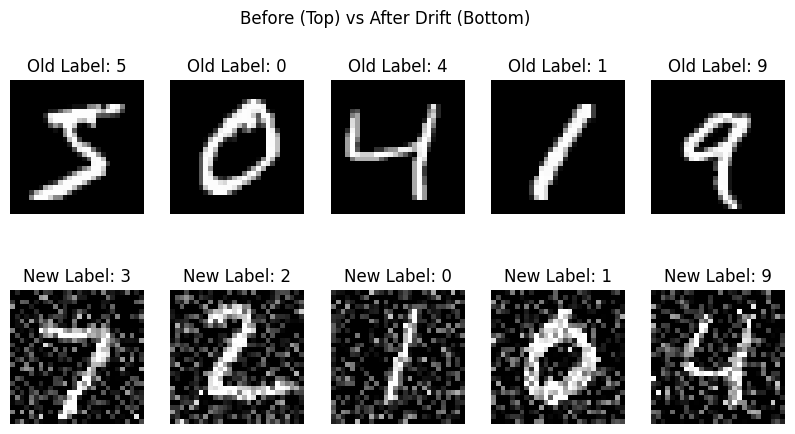

In [28]:
import matplotlib.pyplot as plt

# Show some original vs drifted images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i in range(5):
    axes[0, i].imshow(x_train[i].reshape(28, 28), cmap="gray")
    axes[0, i].set_title(f"Old Label: {y_train[i]}")
    axes[0, i].axis("off")

    axes[1, i].imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    axes[1, i].set_title(f"New Label: {label_map[y_test[i]]}")
    axes[1, i].axis("off")

plt.suptitle("Before (Top) vs After Drift (Bottom)")
plt.show()


###  Label Drift (Using Chi-Square Test)

In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Convert to DataFrame for easier manipulation
train_df = pd.DataFrame({'label': y_train})
test_df = pd.DataFrame({'label': y_test})

# Show initial label distribution for training data
print("Initial Label Distribution in Train Data:")
print(train_df['label'].value_counts())


Initial Label Distribution in Train Data:
label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64


In [ ]:
import random

# Over-represent class '3' and '5' (oversample them)
extra_threes = test_df[test_df['label'] == 3].sample(3000, replace=True)  # Oversample 3s
extra_fives = test_df[test_df['label'] == 5].sample(3000, replace=True)  # Oversample 5s

# Remove class '7' and '9' from test data (under-represent or remove entirely)
test_df = test_df[test_df['label'] != 7]
test_df = test_df[test_df['label'] != 9]

# Add extra '3's and '5's back to the test data
test_df = pd.concat([test_df, extra_threes, extra_fives])

# Shuffle the dataset to mix the oversampled classes with the original ones
test_df = test_df.sample(frac=1).reset_index(drop=True)


In [23]:
## Before drift
# Label distribution in original training data (no drift)
initial_train_label_counts = train_df['label'].value_counts().sort_index()

print("Initial Label Distribution in Train Data (Before Drift):")
print(initial_train_label_counts)


Initial Label Distribution in Train Data (Before Drift):
label
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


In [25]:
## After drift
# Label distribution after label drift (in test data)
new_test_label_counts = test_df['label'].value_counts().sort_index()

print("\nLabel Distribution After Drift (Test Data):")
print(new_test_label_counts)



Label Distribution After Drift (Test Data):
label
0     980
1    1135
2    1032
3    1010
4     982
5     892
6     958
7    1028
8     974
9    1009
Name: count, dtype: int64


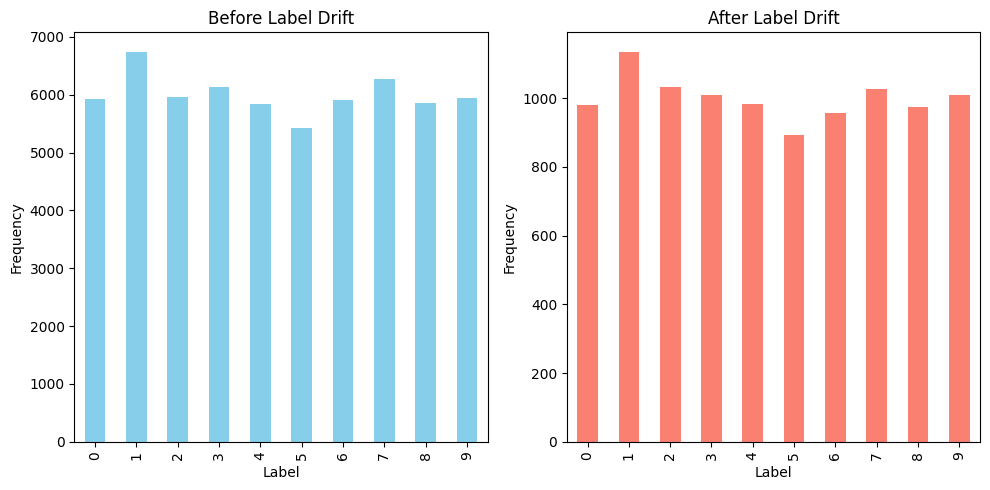

In [26]:
import matplotlib.pyplot as plt

# Plot before and after label drift
plt.figure(figsize=(10, 5))

# Plot for original (before drift)
plt.subplot(1, 2, 1)
initial_train_label_counts.plot(kind='bar', color='skyblue', title='Before Label Drift')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Plot for new (after drift)
plt.subplot(1, 2, 2)
new_test_label_counts.plot(kind='bar', color='salmon', title='After Label Drift')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import chi2_contingency

# Perform Chi-Square Test to detect drift
chi2, p_value, _, _ = chi2_contingency([initial_train_label_counts, new_test_label_counts])

print(f"\n Chi-Square Test p-value for Label Drift: {p_value:.4f}")
if p_value < 0.05:
    print("🚨 Strong Label Drift Detected: Label distribution changed significantly!")
else:
    print("✅ No significant label drift detected.")



📊 Chi-Square Test p-value for Label Drift: 0.9669
✅ No significant label drift detected.
